# CAMVID

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [10]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [12]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05940.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03060.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01410.png')]

In [13]:
lbl_names = get_image_files(path_lbl)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05940.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03060.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01410.png')]

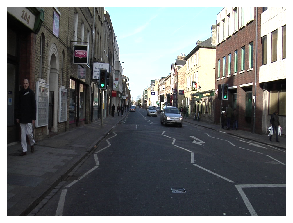

In [14]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize = (5,5))

## Convert img file name to mask file name

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

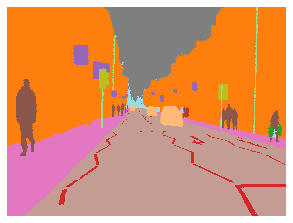

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (5,5), alpha =1 )

In [17]:
src_sz = np.array(mask.shape[1:])
src_sz, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [18]:
codes = np.loadtxt(path/'codes.txt', dtype = str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Datasets

In [0]:
size= src_sz//2 
bs = 8 #batch size

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

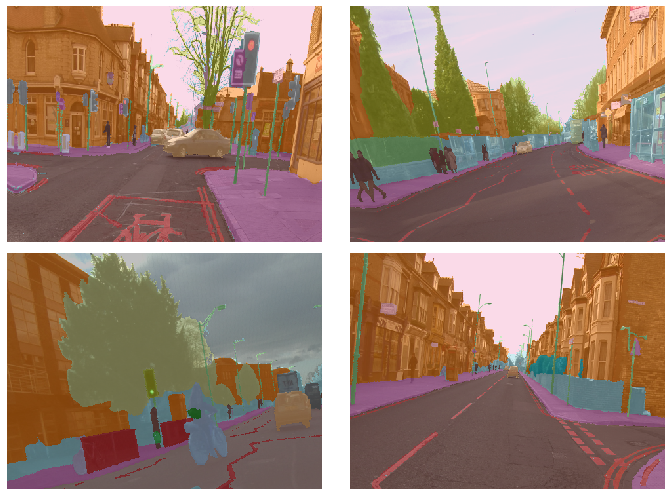

In [22]:
data.show_batch(2, figsize = (10,7))

# Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target!=void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics,wd = wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


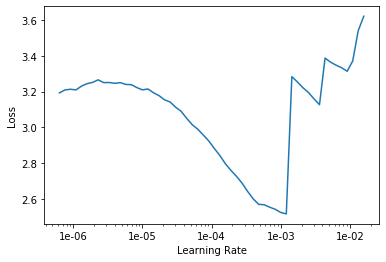

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.154433,0.868757,0.787546,00:57
1,0.821842,0.582873,0.841867,00:55
2,0.683667,0.542843,0.849970,00:54
3,0.631252,0.505935,0.858614,00:55
4,0.621931,0.475803,0.858903,00:55
5,0.792710,0.606661,0.842108,00:55
6,0.637228,0.440554,0.880253,00:55
7,0.583801,0.431939,0.883207,00:54
8,0.544114,0.467209,0.878332,00:55
9,0.469968,0.365798,0.893618,00:55


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

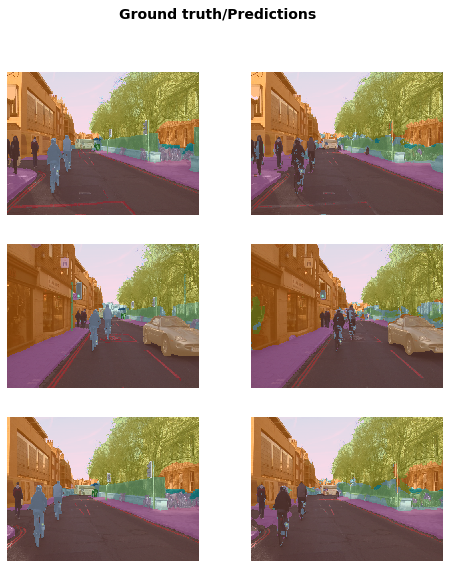

In [35]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [38]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.402370,0.345779,0.895494,00:55
1,0.394512,0.344939,0.895555,00:55
2,0.388541,0.336226,0.896027,00:56
3,0.374737,0.341327,0.897348,00:56
4,0.356001,0.331934,0.899033,00:55
5,0.352424,0.304611,0.914619,00:55
6,0.339525,0.283332,0.921745,00:55
7,0.325527,0.312039,0.915939,00:56
8,0.319560,0.318110,0.909481,00:55
9,0.302984,0.301256,0.920547,00:55


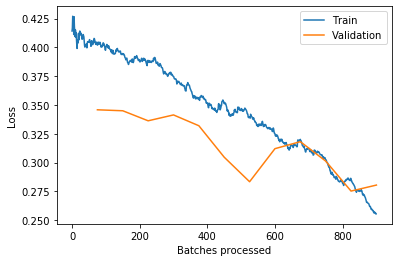

In [39]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2')

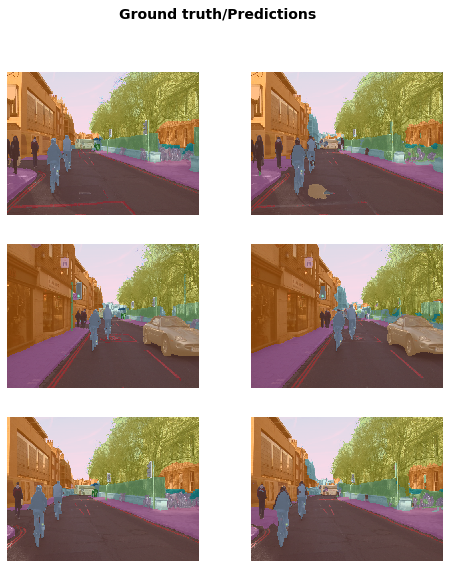

In [41]:
learn.show_results(rows=3, figsize=(8,9))